In [31]:
#Survey ML Project

In [32]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import pandas as pd
import numpy as np
import ipynb
import os
import seaborn as sns
from ipynb.fs.full.SurveyUpload import uploadSurvey
from ipynb.fs.full.DataUpload import getPatterns
from ipynb.fs.full.DataUpload import getUserDay
import json
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import date
from sklearn.impute import SimpleImputer


ML model that tries to predict:
1. Task Completion (Yes or No)
2. Productivity score (1-10)

Using the following data:
1. User survey data from the morning
2. User survy data from the morning and noon
3. User survy data from the morning and noon and # of people talked to / # meetings

And using these models:
1. Basic multiple linear regression
2. Logistic regression
3. SVM
4. More?

In [33]:
df = uploadSurvey()
df['date'] = df['time'].dt.date
morning = df[df['TOD'] == 0]
noon = df[df['TOD'] == 1]
evening = df[df['TOD'] == 2]
df.head()


,time,name,description,sad_happy,stressed_relaxed,unmotivated_motivated,distracted_focused,unaccomplished_accomplished,bored_interested,angry_calm,...,productivity,TOD,when_focus,when_distracted,total_interactions,total_tasks,total_breaks,mind_focus,meaningful,date
0,2023-04-17 09:02:42.287,Lion,Eagerness to go about my To Do's,4,3,3,3,4,4,4,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
1,2023-04-17 09:04:59.898,Rabbit,"monday morning mood, however, motivated to sta...",3,2,4,2,3,4,3,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
2,2023-04-17 09:14:51.081,Snake,I am stressed and feel under pressure.,4,2,3,3,2,3,3,...,5.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
3,2023-04-17 09:20:42.626,Cat,"Stressed, anxious, trying to get into focus mo...",3,2,2,3,3,2,3,...,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17
4,2023-04-17 09:35:00.882,Horse,"medium motivated, bit stressed, loads of meeti...",3,2,3,4,3,2,4,...,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023-04-17


In [34]:
patterns = getPatterns()
patterns.head()

,createdAt,title,name,bundleIdentifier,url,source_file,date,time,datetime,end_time,delta,base_url,category,user
0,7.018782e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,2023-03-30,14:10:42.150009033,2023-03-30 14:10:42.150009033,2023-03-30 14:10:50.292375000,0 days 00:00:08.142365967,<NA>,[other],Monkey
1,7.018783e+08,,Preview,com.apple.Preview,,Monkey-patternsExport.json,2023-03-30,14:10:50.292375,2023-03-30 14:10:50.292375000,2023-03-30 14:10:55.191275879,0 days 00:00:04.898900879,<NA>,[other],Monkey
2,7.018783e+08,,Finder,com.apple.finder,,Monkey-patternsExport.json,2023-03-30,14:10:55.191275879,2023-03-30 14:10:55.191275879,2023-03-30 14:11:12.651991943,0 days 00:00:17.460716064,<NA>,[other],Monkey
3,7.018783e+08,,Notion,notion.id,,Monkey-patternsExport.json,2023-03-30,14:11:12.651991943,2023-03-30 14:11:12.651991943,2023-03-30 14:11:24.028187988,0 days 00:00:11.376196045,<NA>,[genericwork],Monkey
4,7.018783e+08,,Slack,com.tinyspeck.slackmacgap,,Monkey-patternsExport.json,2023-03-30,14:11:24.028187988,2023-03-30 14:11:24.028187988,2023-03-30 14:11:26.361884033,0 days 00:00:02.333696045,<NA>,[other],Monkey


Regression #1

In [35]:
Xcols = ['name', 'sad_happy', 'stressed_relaxed', 'unmotivated_motivated', 'distracted_focused', 'unaccomplished_accomplished', 'bored_interested', 'angry_calm', 'productivity']
ycols = ['productivity']

X = pd.DataFrame(columns=Xcols)
y = pd.DataFrame(columns=ycols)

In [36]:
for index, row in morning.iterrows():
    date_value = row['date']
    name_value = row['name']
    X_vals = morning.loc[index, Xcols]
    
    matching_rows = evening[(evening['date'] == date_value) & (evening['name'] == name_value)]
    # If there's a match, grab the values and append to X and y
    if not matching_rows.empty:
        y_vals = matching_rows[ycols].iloc[0]
        X.loc[X.shape[0]] = X_vals.tolist()
        y.loc[y.shape[0]] = y_vals.tolist()

In [37]:
X.drop('name', axis=1, inplace=True)

In [38]:
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to our data
X_imputed = imputer.fit_transform(X)
X = pd.DataFrame(X_imputed, columns=X.columns)
y_imputed = imputer.fit_transform(y)
y = pd.DataFrame(y_imputed, columns=y.columns)
features = Xcols[1:]


In [39]:
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predictions
y_pred = model.predict(X)

In [40]:
# Print coefficients and intercept
print("Intercept:", model.intercept_)

for idx, coef in enumerate(model.coef_[0]):
    print(Xcols[idx+1], ": ", coef)

# Print R-squared and MSE
print("R-squared:", r2_score(y, y_pred))
print("Mean Squared Error:", mean_squared_error(y, y_pred))

Intercept: [3.8435881]
sad_happy :  0.501967053938469
stressed_relaxed :  -0.20072564136014592
unmotivated_motivated :  0.07030738374225753
distracted_focused :  0.3648572666093686
unaccomplished_accomplished :  -0.4409954667387886
bored_interested :  0.014227227579237087
angry_calm :  0.1885689472130051
productivity :  0.10885609771110843
R-squared: 0.14498192318816572
Mean Squared Error: 3.295535382750186


In [41]:
print(X[features[0]])
print(y_pred.shape)

0     4.0
1     3.0
2     4.0
3     3.0
4     4.0
     ... 
89    5.0
90    4.0
91    4.0
92    4.0
93    3.0
Name: sad_happy, Length: 94, dtype: float64
(94, 1)


In [42]:
print(model.coef_)

[[ 0.50196705 -0.20072564  0.07030738  0.36485727 -0.44099547  0.01422723
   0.18856895  0.1088561 ]]


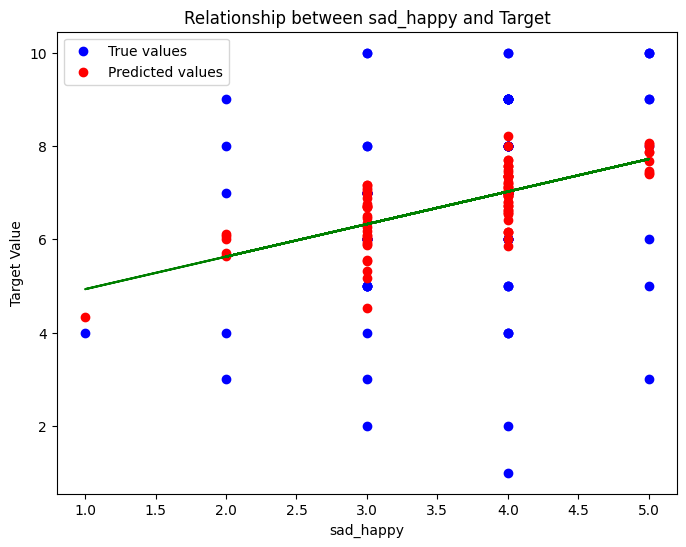

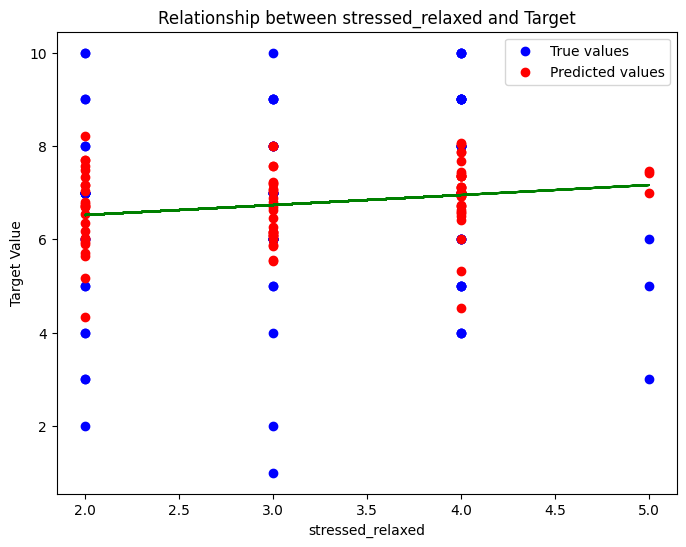

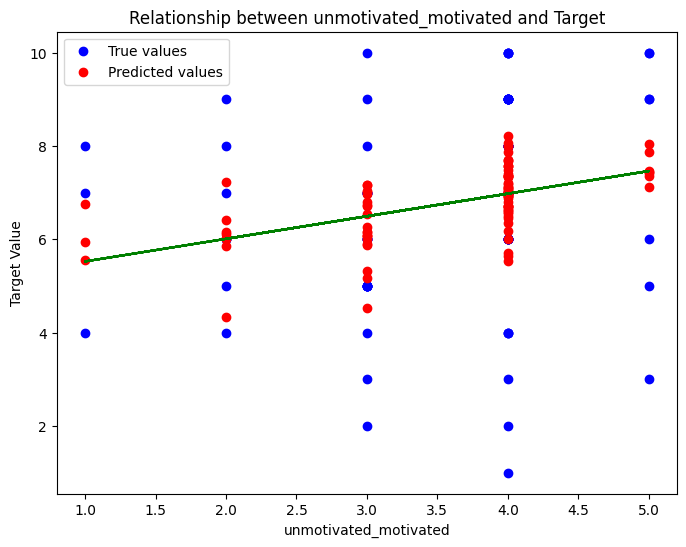

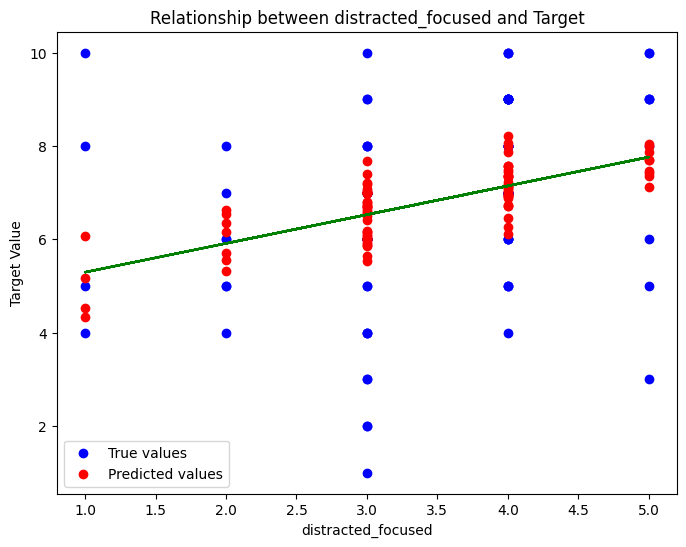

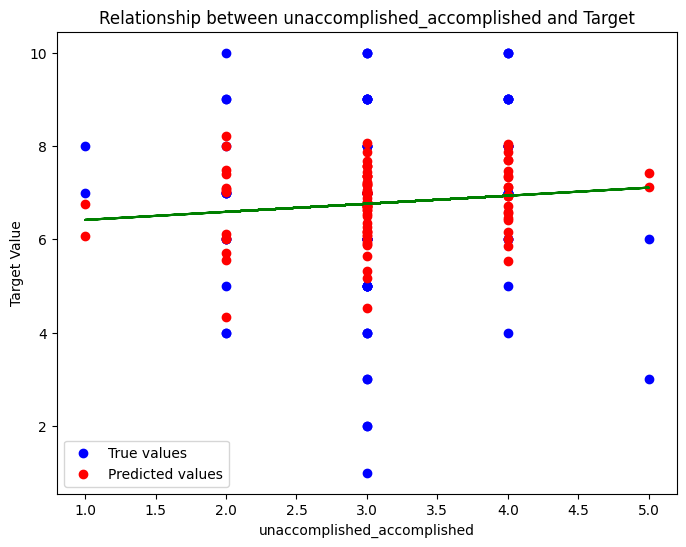

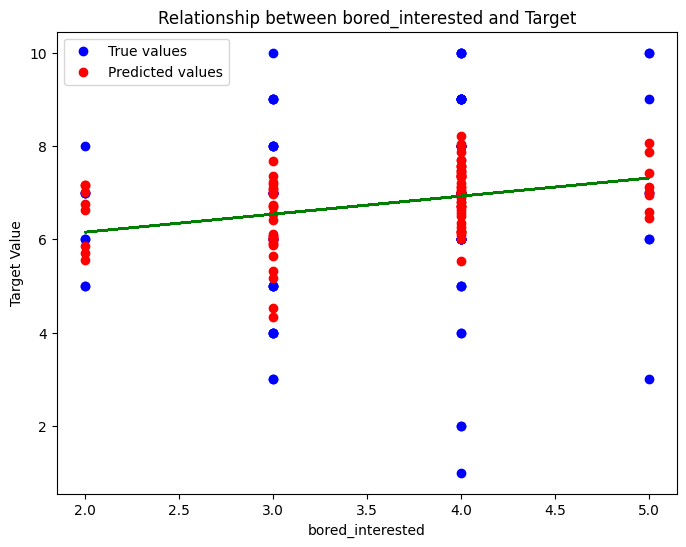

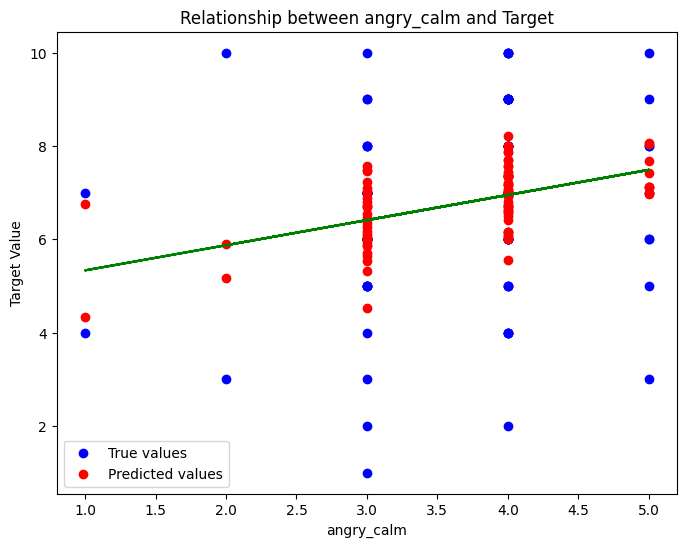

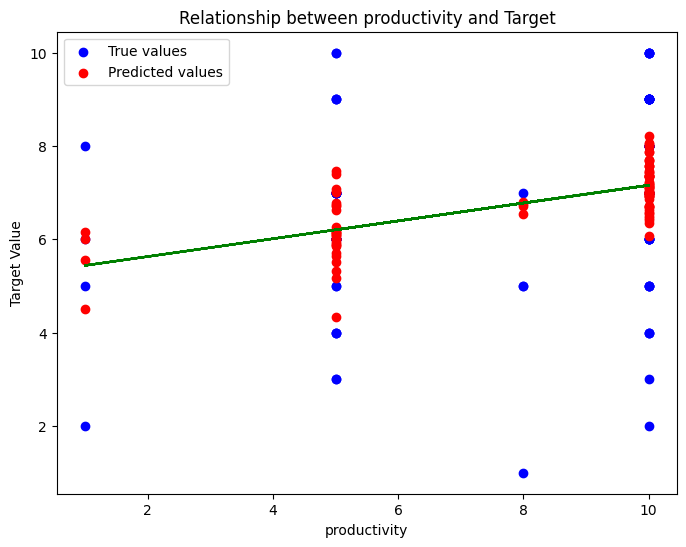

In [44]:
for feature in features:
    plt.figure(figsize=(8, 6))
    
    # Scatter plots
    plt.scatter(X[feature], y, color='blue', label='True values')  # Original data
    plt.scatter(X[feature], y_pred, color='red', label='Predicted values')  # Model's predictions
    
    # Generate and plot trendline for the original data
    m, b = np.polyfit(X[feature], y, 1)  # 1 for linear regression
    plt.plot(X[feature], m*X[feature] + b, color='green')  # Trendline
    
    # Rest of the plotting properties
    plt.title(f"Relationship between {feature} and Target")
    plt.xlabel(feature)
    plt.ylabel('Target Value')
    plt.legend()
    plt.show()
